# Определение возраста покупателей

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.



**Инструкция по выполнению проекта**

- Проведите исследовательский анализ набора фотографий.

- Подготовьте данные к обучению.

- Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt

In [4]:
# Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.shape

(7591, 2)

In [7]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [15]:
labels.real_age.min()

1

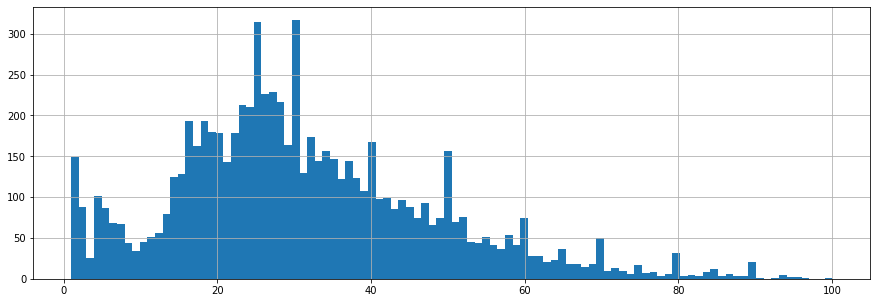

In [21]:
#график распределения возраста
labels.real_age.hist(bins=100,figsize=(15,5))

Возраст в выборке от 1 года до 100 лет. Мало людей пожилого возраста, модель возможно плохо обучится на этих возрастных группах ввиду малого количества примеров.


Наблюдаем один основной пик:
- от 20 до 40




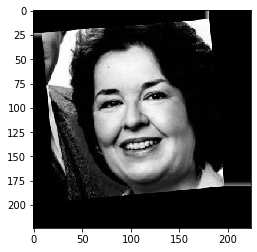

In [22]:
features, target = next(train_gen_flow)

# Вывод одной фотографии
plt.imshow(features[0])

В датасете есть черно-белые фотографии. 

In [11]:
features.shape

(32, 224, 224, 3)

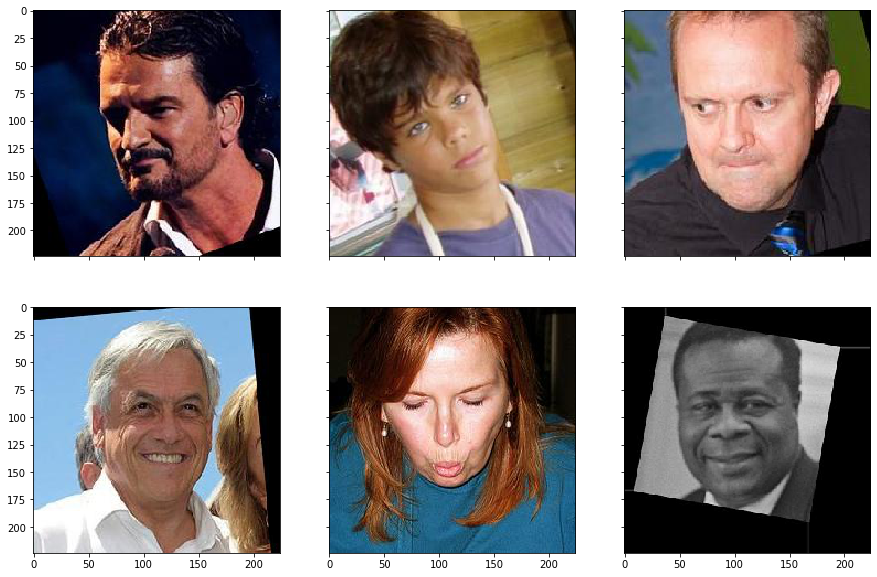

In [10]:
#Вывод нескольких фотографий.
features, target  = train_gen_flow.next()

fig, axes = plt.subplots(ncols=3,nrows=2, sharex=True, sharey=True, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(features[i], interpolation='none')

plt.show()

Вывод: 

Количество изображений 7591, размер изображений 244х244 с тремя каналами. Возраст в выборке от 1 года до 100 лет. Мало людей пожилого возраста. Основной пик от 20 до 40 лет. Есть черно-белые фотографии.



## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
 
def load_train(path):
 
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=f'{path}final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345) 
 
    return (train_gen_flow)
 
 
 
def load_test(path):
 
    labels = pd.read_csv('/datasets/faces/labels.csv')
    validation_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255)
    validation_gen_flow = validation_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=f'{path}final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345) 
 
    return (validation_gen_flow)
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
 
    optimizer = Adam(0.0005)
 
    model.compile(optimizer=optimizer, loss='mse',  metrics=['mae']) 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              batch_size=batch_size,
              verbose=2, epochs=epochs
             )
 
    return model>

```

In [ ]:
```

Train for 178 steps, validate for 60 steps
Epoch 1/15
2021-05-02 05:50:32.545452: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-02 05:50:32.854032: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 50s - loss: 193.0878 - mae: 10.4061 - val_loss: 388.1403 - val_mae: 14.7475
Epoch 2/15
178/178 - 41s - loss: 104.4735 - mae: 7.7653 - val_loss: 391.4953 - val_mae: 14.8182
Epoch 3/15
178/178 - 41s - loss: 69.4938 - mae: 6.3628 - val_loss: 422.0166 - val_mae: 15.5217
Epoch 4/15
178/178 - 41s - loss: 43.3627 - mae: 5.0618 - val_loss: 213.6368 - val_mae: 10.7744
Epoch 5/15
178/178 - 41s - loss: 30.7517 - mae: 4.2628 - val_loss: 104.3801 - val_mae: 7.6767
Epoch 6/15
178/178 - 40s - loss: 22.7311 - mae: 3.7293 - val_loss: 86.4711 - val_mae: 7.0891
Epoch 7/15
178/178 - 41s - loss: 17.5152 - mae: 3.2347 - val_loss: 86.0207 - val_mae: 7.1225
Epoch 8/15
178/178 - 41s - loss: 13.8524 - mae: 2.8716 - val_loss: 95.8773 - val_mae: 7.4893
Epoch 9/15
178/178 - 41s - loss: 12.5260 - mae: 2.7027 - val_loss: 78.5545 - val_mae: 6.5713
Epoch 10/15
178/178 - 40s - loss: 9.9145 - mae: 2.4129 - val_loss: 79.4282 - val_mae: 6.8210
Epoch 11/15
178/178 - 41s - loss: 8.4602 - mae: 2.2138 - val_loss: 71.3127 - val_mae: 6.2581
Epoch 12/15
178/178 - 41s - loss: 7.9219 - mae: 2.1421 - val_loss: 88.6585 - val_mae: 7.2903
Epoch 13/15
178/178 - 41s - loss: 7.1034 - mae: 2.0080 - val_loss: 74.1370 - val_mae: 6.4210
Epoch 14/15
178/178 - 41s - loss: 6.4074 - mae: 1.9237 - val_loss: 72.6525 - val_mae: 6.4871
Epoch 15/15
178/178 - 41s - loss: 6.0845 - mae: 1.8876 - val_loss: 77.6596 - val_mae: 6.6150

```

## Анализ обученной модели

Задачей было обучить модель, которая поможет определять возраст клиентов. MAE необходимо было добиться меньше 7.

Результат получилось добиться с архитектурой ResNet50, на выходе с функцией активации relu. После 6 эпох обучения значение MAE на валидационой выборки составляет меньше 7.